In [12]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row, SQLContext, Window
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType, IntegerType, ArrayType, BooleanType
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.sql import functions as F 
from pyspark.sql.functions import explode, col, udf, desc, mean, stddev, log, log10, when
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.functions import lit
from pyspark.rdd import RDD
from pyspark.sql.functions import isnull, isnan
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
import json
#coding:utf-8
'%matplotlib inline' 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, Word2Vec, HashingTF, IDF, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import RegressionEvaluator

In [13]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jojocao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
conf = SparkConf().setAppName("Project").setMaster("local[5]") #Initialize spark context using 4 local cores as workers
sc = SparkContext(conf=conf)  
spark = SparkSession(sc)

### Import data

In [14]:
train = spark.read.format('parquet').load('train.parquet')

test = spark.read.format('parquet').load('test.parquet')

valid = spark.read.format('parquet').load('valid.parquet')

In [7]:
vec_col = [col for col in train.columns if 'Vec' in col]
# input_feature = vec_col + ['num_comments', 'bool_mean','cate_mean']
# assembler = VectorAssembler(inputCols=input_feature, outputCol='features')
# train_df = assembler.transform(train)
# test_df = assembler.transform(test)
# valid_df = assembler.transform(valid)

In [15]:
def trans_score(s):
    if s == 0:
        return 1
    elif s>0 and s<10:
        return 2
    elif s>=10 and s<=100:
        return 3
    else:
        return 4
udf_score = udf(trans_score, IntegerType())

### Linear Regression

In [141]:
input_feature = vec_col + ['comments_norm', 'title_tfidf', 'cate_mean','bool_mean']
assembler = VectorAssembler(inputCols=input_feature, outputCol='features')
train_ = assembler.transform(train)
test_ = assembler.transform(test)
valid_ = assembler.transform(valid)

In [142]:
train_ = train_.withColumn('label', udf_score('score'))
test_ = test_.withColumn('label', udf_score('score'))
valid_ = valid_.withColumn('label', udf_score('score'))

In [143]:
lr = LinearRegression(featuresCol = "features", labelCol="score", maxIter=10, regParam=0.03, elasticNetParam=0.8)
lrmodel = lr.fit(train_)
pred_train = lrmodel.transform(train_)
pred_test = lrmodel.transform(test_)
pred_valid = lrmodel.transform(valid_)

In [144]:
eval = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName='rmse')
print('Train RMSE:', eval.evaluate(pred_train))

train_lr = []
for i in range(1,5):
    train_lr.append(eval.evaluate(pred_train.where(F.col('label')==i)))
train_lr.append(eval.evaluate(pred_train))

Train RMSE: 16.41928489748523


In [145]:
train_lr

[8.273425092666226,
 10.790328047185762,
 24.18997783205239,
 83.95365404590669,
 16.41928489748523]

In [146]:
eval = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName='rmse')
print('Test RMSE:', eval.evaluate(pred_test))

test_lr = []
for i in range(1,5):
    test_lr.append(eval.evaluate(pred_test.where(F.col('label')==i)))
test_lr.append(eval.evaluate(pred_test))

Test RMSE: 27.777792074823765


In [147]:
test_lr

[17.650895911031686,
 24.70418309020599,
 31.148594306194006,
 124.77564292352473,
 27.777792074823765]

In [148]:
eval = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName='rmse')
print('OOT RMSE:', eval.evaluate(pred_valid))

oot_lr = []
for i in range(1,5):
    oot_lr.append(eval.evaluate(pred_valid.where(F.col('label')==i)))
oot_lr.append(eval.evaluate(pred_valid))

OOT RMSE: 31.38773372824923


In [149]:
oot_lr

[17.1226696651456,
 35.937806899590456,
 33.33254956728187,
 142.3879181503427,
 31.38773372824923]

In [150]:
lr_dict = dict()
lr_dict['train']=train_lr
lr_dict['test']=test_lr
lr_dict['oot']=oot_lr

import pandas as pd
df_lr = pd.DataFrame(lr_dict, index=[1,2,3,4,'RMSE'])
df_lr

,train,test,oot
1,8.273425,17.650896,17.122670
2,10.790328,24.704183,35.937807
3,24.189978,31.148594,33.332550
4,83.953654,124.775643,142.387918
RMSE,16.419285,27.777792,31.387734


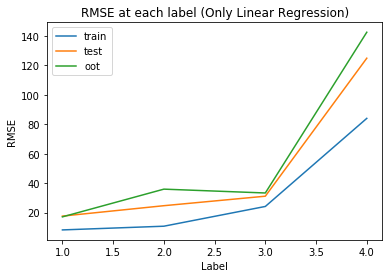

In [151]:
plt.plot([1, 2, 3, 4], train_lr[:4], label='train')
plt.plot([1, 2, 3, 4], test_lr[:4], label='test')
plt.plot([1, 2, 3, 4], oot_lr[:4], label='oot')
plt.xlabel('Label')
plt.ylabel('RMSE')
plt.title('RMSE at each label (Only Linear Regression)')
plt.legend()
plt.show()

### Kmeans+Linear Regression

In [155]:
input_feature = vec_col + ['num_comments', 'bool_mean','cate_mean','title_word2vec','url_word2vec']
assembler = VectorAssembler(inputCols=input_feature, outputCol='features')
train_df = assembler.transform(train)
test_df = assembler.transform(test)
valid_df = assembler.transform(valid)

In [154]:
input_feature

['authorVec',
 'whitelistVec',
 'brand_safe_Vec',
 'can_gild_Vec',
 'is_crosspostable_Vec',
 'no_follow_Vec',
 'over_18_Vec',
 'subreddit_Vec',
 'subreddit_type_Vec',
 'num_comments',
 'bool_mean',
 'cate_mean',
 'title_word2vec',
 'url_word2vec']

In [156]:
train_df = train_df.withColumn('label', udf_score('score'))
test_df = test_df.withColumn('label', udf_score('score'))
valid_df = valid_df.withColumn('label', udf_score('score'))

In [158]:
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(train_df)
train_kmeans = model.transform(train_df)


# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(train_df)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 75843.70359201365
Cluster Centers: 
[ 9.42369891e-01  5.76301088e-02  7.35273939e-01  2.32284622e-01
  3.24414388e-02  7.35371949e-01  2.64628051e-01  9.42369891e-01
  5.76301088e-02  8.55336666e-01  1.44663334e-01  9.72557091e-01
  2.74429089e-02  9.41095756e-01  5.89042438e-02  6.23934137e-01
  1.33882192e-01  6.20405763e-02  4.93972361e-02  3.23434284e-02
  2.64628051e-02  2.14642752e-02  1.10751740e-02  8.91894541e-03
  8.13486230e-03  6.46868568e-03  3.43036362e-03  3.33235323e-03
  2.35224934e-03  2.05821817e-03  1.37214545e-03  1.17612467e-03
  1.07811428e-03  3.92041556e-04  2.94031167e-04  1.96020778e-04
  9.80103891e-05  9.80103891e-05  6.23934137e-01  3.63030481e-01
  1.30353818e-02  3.42840341e-01  1.25043759e+00  3.68446076e-01
  2.18788869e-03 -1.62767113e-03  6.64837208e-03  2.76906715e-03
  3.18380306e-03 -4.50279430e-04 -1.59532914e-03  6.24848402e-03
  3.80029604e-03 -3.28598529e-03 -7.48281687e-04  5.91444935e-03
  1.09562794e-02  7

In [159]:
train_kmeans = model.transform(train_df)
count_num=dict()
for i in range(6):
    
    c = int(train_kmeans.where(F.col('prediction')==i).count())
    count_num[i]=c

In [160]:
count_num

{0: 10203, 1: 4, 2: 1876, 3: 30, 4: 117, 5: 295}

In [161]:
train_kmeans.groupby('prediction','label').count().sort('prediction').show(30)

+----------+-----+-----+
|prediction|label|count|
+----------+-----+-----+
|         0|    1| 7494|
|         0|    2| 2438|
|         0|    4|   11|
|         0|    3|  260|
|         1|    4|    3|
|         1|    3|    1|
|         2|    3|  649|
|         2|    4|   47|
|         2|    2| 1179|
|         2|    1|    1|
|         3|    3|    7|
|         3|    4|   23|
|         4|    3|   46|
|         4|    4|   67|
|         4|    2|    4|
|         5|    4|  100|
|         5|    2|   10|
|         5|    3|  185|
+----------+-----+-----+



In [162]:
test_kmeans = model.transform(test_df)
count_test=dict()
for i in range(6):
    
    c = int(test_kmeans.where(F.col('prediction')==i).count())
    count_test[i]=c

In [163]:
valid_kmeans = model.transform(valid_df)
count_valid=dict()
for i in range(6):
    c = int(valid_kmeans.where(F.col('prediction')==i).count())
    count_valid[i]=c

In [ ]:
#count_valid

In [ ]:
#valid_kmeans.groupby('prediction','label').count().sort('prediction').show(30)

In [164]:

a = train_kmeans.withColumn('kmeans', when(((F.col('prediction') == 3) |(F.col('prediction') == 1)), 4)\
                                     .otherwise(F.col('prediction')))\
                .drop('prediction','features')

b = test_kmeans.withColumn('kmeans', when(((F.col('prediction') == 3) |(F.col('prediction') == 1)), 4)\
                                     .otherwise(F.col('prediction')))\
                .drop('prediction','features')

c = valid_kmeans.withColumn('kmeans', when(((F.col('prediction') == 3) |(F.col('prediction') == 1)), 4)\
                                     .otherwise(F.col('prediction')))\
                .drop('prediction','features')

In [165]:
vec_col = [col for col in train.columns if 'Vec' in col]
input_feature = vec_col + ['comments_norm', 'cate_mean','bool_mean']

In [166]:
assembler = VectorAssembler(inputCols=input_feature, outputCol='features')
aa = assembler.transform(a)
bb = assembler.transform(b)
cc = assembler.transform(c)

In [167]:
rmse_tr = 0
for i in [0,2,4,5]:
    train = aa.where(F.col('kmeans')==i)
    lr = LinearRegression(featuresCol = "features", labelCol="score", maxIter=10, regParam=0.03, elasticNetParam=0.8)
    lrmodel = lr.fit(train)

    ##test
    test = aa.where(F.col('kmeans')==i)
    if int(test.count())>0:
        test_pred = lrmodel.transform(test)
        test_pred = test_pred.withColumn('pred', when(F.col('prediction')<0,0).otherwise(F.col('prediction')))
        eval = RegressionEvaluator(labelCol="score", predictionCol="pred", metricName='rmse')
        print('Keans: ', i, 'Rows: ', int(test.count()))
        print('RMSE:', eval.evaluate(test_pred))
        r = eval.evaluate(test_pred)
        rmse_tr += (int(test.count())*(r**2))
    else:
        pass
    
    ##valid
print(np.sqrt(rmse_tr/int(aa.count())))

Keans:  0 Rows:  10203
RMSE: 6.107333733618212
Keans:  2 Rows:  1876
RMSE: 24.636308380666197
Keans:  4 Rows:  151
RMSE: 94.37809354326028
Keans:  5 Rows:  295
RMSE: 71.13962947569382
18.651423046829606


In [168]:
rmse_te = 0
for i in [0,2,4,5]:
    train = aa.where(F.col('kmeans')==i)
    lr = LinearRegression(featuresCol = "features", labelCol="score", maxIter=10, regParam=0.03, elasticNetParam=0.8)
    lrmodel = lr.fit(train)
    
    
    ##train
    
    ##test
    test = bb.where(F.col('kmeans')==i)
    if int(test.count())>0:
        test_pred = lrmodel.transform(test)
        test_pred = test_pred.withColumn('pred', when(F.col('prediction')<0,0).otherwise(F.col('prediction')))
        eval = RegressionEvaluator(labelCol="score", predictionCol="pred", metricName='rmse')
        #print(i, ' ', int(test.count()))
        print('Keans: ', i, 'Rows: ', int(test.count()))
        print('RMSE:', eval.evaluate(test_pred))
        r = eval.evaluate(test_pred)
        #print(r**2)
        rmse_te += (int(test.count())*(r**2))
    else:
        pass
    
    ##valid
print((rmse_te/int(bb.count()))**0.5)

Keans:  0 Rows:  9911
RMSE: 5.605810458702182
Keans:  2 Rows:  2054
RMSE: 19.661126072506804
Keans:  4 Rows:  233
RMSE: 87.72935696969878
Keans:  5 Rows:  358
RMSE: 65.15752239770033
18.75932130477061


In [169]:
rmse_va = 0
result = dict()

for i in [0,2,4,5]:
    train = aa.where(F.col('kmeans')==i)
    lr = LinearRegression(featuresCol = "features", labelCol="score", maxIter=10, regParam=0.03, elasticNetParam=0.8)
    lrmodel = lr.fit(train)
    
    
    ##train
    
    ##test
    test = cc.where(F.col('kmeans')==i)
    if int(test.count())>0:
        test_pred = lrmodel.transform(test)
        test_pred = test_pred.withColumn('pred', when(F.col('prediction')<0,0).otherwise(F.col('prediction')))
        eval = RegressionEvaluator(labelCol="score", predictionCol="pred", metricName='rmse')
        print(i, ' ', int(test.count()))
        print('RMSE:', eval.evaluate(test_pred))
        rmse_va += (int(test.count())*(eval.evaluate(test_pred))**2)
        result[i]=test_pred.select('pred','score','label').collect()
    else:
        pass
    
    ##valid
print((rmse_va/int(valid.count()))**0.5)

0   12018
RMSE: 6.110824222855583
2   1951
RMSE: 19.557468243350865
4   344
RMSE: 100.65498517261102
5   388
RMSE: 54.86260868727704
19.94496056751909


In [48]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.regression import LabeledPoint
    
rmse = 0
for i in [0,2,4,5]:
    train = aa.where(F.col('kmeans')==i)
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=10)
    dtModel = dt.fit(train)
    
    test = cc.where(F.col('kmeans')==i)
    if int(test.count())>0:
        result = dtModel.transform(test)
        acc = result.where(result['label']==result['prediction']).count()/result.count()
        print(int(test.count()))
        print(acc)
#         test_pred = test_pred.withColumn('pred', when(F.col('prediction')<0,0).otherwise(F.col('prediction')))
#         eval = RegressionEvaluator(labelCol="score", predictionCol="pred", metricName='rmse')
#         print(i, ' ', int(test.count()))
#         print('RMSE:', eval.evaluate(test_pred))
#         rmse += (int(test.count())*eval.evaluate(test_pred))
    else:
        pass
#print(rmse/int(valid_fea.count()))

12018
0.8291729073057081
1951
0.6940030753459764
344
0.4796511627906977
388
0.6314432989690721


In [49]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

In [170]:
tr_rmse = 0
te_rmse = 0
va_rmse = 0

tr = dict()
te = dict()
va = dict()

for i in range(1,5):
    tr[i] =[]
    te[i] =[]
    va[i] =[]


In [171]:
for i in [0,2,4,5]:
    train = aa.where(F.col('kmeans')==i)
    lr = LinearRegression(featuresCol = "features", labelCol="score", maxIter=10, regParam=0.03, elasticNetParam=0.8)
    lrmodel = lr.fit(train)
    
    ##train
    test = aa.where(F.col('kmeans')==i)
    test_pred = lrmodel.transform(test)
    test_pred = test_pred.withColumn('pred', when(F.col('prediction')<0,0).otherwise(F.col('prediction')))
    
    for label in range(1,5):
        pred = test_pred.where(F.col('label')==label)
        if int(pred.count())>0:
            eval = RegressionEvaluator(labelCol="score", predictionCol="pred", metricName='rmse')
            tr[label].append((int(pred.count())*(eval.evaluate(pred))**2))
            print(tr[label])
        else:
            pass
    ##test
    test = bb.where(F.col('kmeans')==i)
    test_pred = lrmodel.transform(test)
    test_pred = test_pred.withColumn('pred', when(F.col('prediction')<0,0).otherwise(F.col('prediction')))
    
    for label in range(1,5):
        pred = test_pred.where(F.col('label')==label)
        if int(pred.count())>0:
            eval = RegressionEvaluator(labelCol="score", predictionCol="pred", metricName='rmse')
            te[label].append((int(pred.count())*(eval.evaluate(pred))**2))
            print(te[label])
        else:
            pass
    ##oot
    test = cc.where(F.col('kmeans')==i)
    test_pred = lrmodel.transform(test)
    test_pred = test_pred.withColumn('pred', when(F.col('prediction')<0,0).otherwise(F.col('prediction')))
    
    for label in range(1,5):
        pred = test_pred.where(F.col('label')==label)
        if int(pred.count())>0:
            eval = RegressionEvaluator(labelCol="score", predictionCol="pred", metricName='rmse')
            va[label].append((int(pred.count())*(eval.evaluate(pred))**2))
            print(va[label])
        else:
            pass
#print((rmse/int(valid.count()))**0.5)

[48350.58249728416]
[23214.195417768882]
[130959.35304549763]
[178042.9260201132]
[36546.6833034127]
[17986.49468639483]
[142449.10031342864]
[114471.99581571079]
[36125.24007696696]
[12543.899543681495]
[180718.4030224542]
[219390.6886568531]
[48350.58249728416, 286.722462408027]
[23214.195417768882, 168472.84523386238]
[130959.35304549763, 309452.610729225]
[178042.9260201132, 660421.6891912937]
[17986.49468639483, 119366.90915031006]
[142449.10031342864, 277496.7327063806]
[114471.99581571079, 397130.34845701803]
[36125.24007696696, 231.15983280996838]
[12543.899543681495, 96549.08721941062]
[180718.4030224542, 300935.704235296]
[219390.6886568531, 348530.9432514477]
[23214.195417768882, 168472.84523386238, 38737.45426408754]
[130959.35304549763, 309452.610729225, 430371.4531506927]
[178042.9260201132, 660421.6891912937, 875881.9982551386]
[36546.6833034127, 33802.618808317784]
[17986.49468639483, 119366.90915031006, 65871.85204865065]
[142449.10031342864, 277496.7327063806, 639188.

In [172]:
trr = []
tee = []
vaa = []
for i in range(1,5):
    trr.append(np.sqrt(sum(tr[i])/int(aa.where(F.col('label')==i).count())))
    tee.append(np.sqrt(sum(te[i])/int(bb.where(F.col('label')==i).count())))
    vaa.append(np.sqrt(sum(va[i])/int(cc.where(F.col('label')==i).count())))

In [173]:
trr.append(18.651423046829606)
tee.append(18.75932130477061)
vaa.append(19.94496056751909)

In [176]:
rmse_dict = dict()
rmse_dict['train_kmeans']=trr

rmse_dict['test_kmeans']=tee

rmse_dict['oot_kmeans']=vaa
rmse_dict['train_lr']=train_lr
rmse_dict['test_lr']=test_lr
rmse_dict['oot_lr']=oot_lr

import pandas as pd
df = pd.DataFrame(rmse_dict, index=[1,2,3,4,'RMSE'])
df

,train_kmeans,test_kmeans,oot_kmeans,train_lr,test_lr,oot_lr
1,2.547410,3.000881,3.189961,8.273425,17.650896,17.122670
2,8.851515,10.060779,11.459232,10.790328,24.704183,35.937807
3,33.213005,34.096675,34.276127,24.189978,31.148594,33.332550
4,104.817331,98.900651,109.634594,83.953654,124.775643,142.387918
RMSE,18.651423,18.759321,19.944961,16.419285,27.777792,31.387734


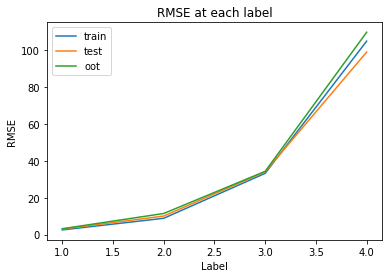

In [257]:
plt.plot([1, 2, 3, 4], trr, label='train')
plt.plot([1, 2, 3, 4], tee, label='test')
plt.plot([1, 2, 3, 4], vaa, label='oot')
plt.xlabel('Label')
plt.ylabel('RMSE')
plt.title('RMSE at each label')
plt.legend()
plt.show()

In [178]:
import numpy as np
np.sqrt(sum(rmse[1])/int(cc.where(F.col('label')==1).count()))

3.7139030946268496

In [180]:
np.sqrt(sum(rmse[2])/int(cc.where(F.col('label')==2).count()))

11.6439721057355

In [181]:
np.sqrt(sum(rmse[3])/int(cc.where(F.col('label')==3).count()))

34.27612742388009

In [182]:
np.sqrt(sum(rmse[4])/int(cc.where(F.col('label')==4).count()))

109.63459392642542

In [203]:
#np.sqrt((sum(rmse[1])+sum(rmse[2])+sum(rmse[3])+sum(rmse[4]))/14701)
tr_rmse

48350.58249728416

In [200]:
va

[4.172565469623959, 11.8258264246659, 34.27612742388009, 109.63459392642542]